# **🐍 Pythonデモコード：ガラーキン法（FEM）の実演**

両端固定の棒に、等分布荷重がかかっている。

要素数を変えると、近似解（青線）が厳密解（赤点線）にどう近づくかを見てみましょう。

--- 要素数 10 の場合の全体剛性行列 [K] ---
[[ 10. -10.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-10.  20. -10.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. -10.  20. -10.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -10.  20. -10.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. -10.  20. -10.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. -10.  20. -10.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -10.  20. -10.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. -10.  20. -10.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. -10.  20. -10.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -10.  20. -10.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. -10.  10.]]

対角成分に数字が集まり、帯状行列になっていることが分かります。


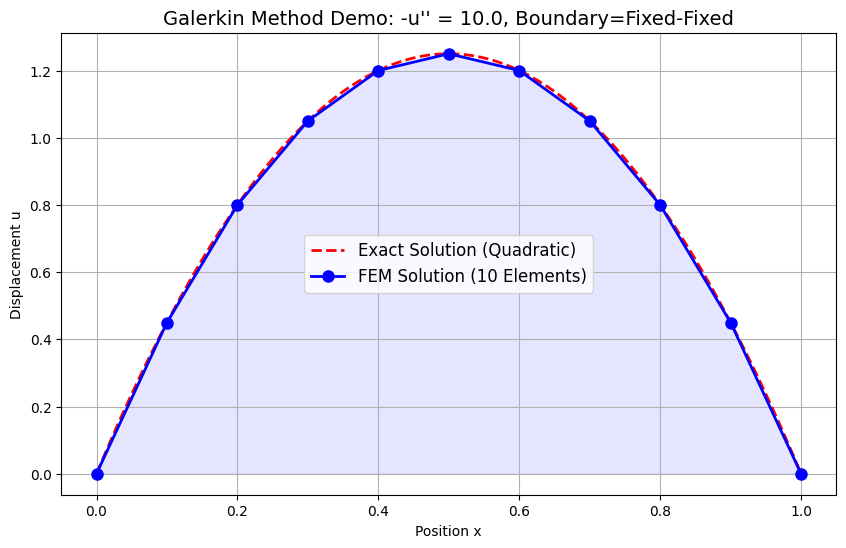

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def solve_fem_1d(num_elements=5):
    """
    1次元ガラーキン法（FEM）による微分方程式 -u'' = f の求解デモ
    境界条件: u(0) = 0, u(L) = 0 (両端固定)
    """
    # --- 1. 問題設定 (物理定数) ---
    L = 1.0       # 全長
    f = 10.0      # 分布荷重 (一定)

    # --- 2. メッシュ生成 (離散化) ---
    num_nodes = num_elements + 1
    x_nodes = np.linspace(0, L, num_nodes) # 節点座標
    le = L / num_elements                  # 要素長さ

    # --- 3. 行列の初期化 ---
    K_global = np.zeros((num_nodes, num_nodes)) # 全体剛性行列
    F_global = np.zeros(num_nodes)              # 全体荷重ベクトル

    # --- 4. 要素剛性行列の組み立て (Assembly) ---
    # スライドで導出した [k] = (1/le) * [[1, -1], [-1, 1]]
    k_elem = (1 / le) * np.array([[1, -1],
                                  [-1, 1]])

    # スライドで導出した {f} = (f*le/2) * [1, 1]
    f_elem = (f * le / 2) * np.array([1, 1])

    for i in range(num_elements):
        # 節点番号 (i, i+1) に対応する位置に足し込む
        node1, node2 = i, i + 1

        # 剛性行列の足し込み
        K_global[node1, node1] += k_elem[0, 0]
        K_global[node1, node2] += k_elem[0, 1]
        K_global[node2, node1] += k_elem[1, 0]
        K_global[node2, node2] += k_elem[1, 1]

        # 荷重ベクトルの足し込み
        F_global[node1] += f_elem[0]
        F_global[node2] += f_elem[1]

    # --- 5. 境界条件の処理 (u=0 の固定) ---
    # 両端 (Node 0 と Node N) を固定するため、行列を縮小するか、
    # ペナルティ法を使うが、ここでは分かりやすく「計算対象から外す」処理を行う

    # 自由な節点（計算すべき未知数）はインデックス 1 から N-1 まで
    free_nodes = list(range(1, num_nodes - 1))

    # 縮小剛性方程式 K' u' = F'
    K_reduced = K_global[np.ix_(free_nodes, free_nodes)]
    F_reduced = F_global[free_nodes]

    # --- 6. 連立方程式を解く (Solver) ---
    u_solution = np.zeros(num_nodes)
    # numpyの線形代数ソルバーで解く
    u_solution[free_nodes] = np.linalg.solve(K_reduced, F_reduced)

    return x_nodes, u_solution, L, f

# --- 実行と可視化 ---
# 要素数を変えて実験（例: 4要素）
N_ELEM = 4
x_fem, u_fem, L, f = solve_fem_1d(N_ELEM)

# 厳密解 (Exact Solution): -u'' = f => u = (f/2)*x*(L-x)
x_exact = np.linspace(0, L, 100)
u_exact = (f / 2) * x_exact * (L - x_exact)

# プロット
plt.figure(figsize=(10, 6))
plt.plot(x_exact, u_exact, 'r--', label='Exact Solution (Quadratic)', linewidth=2)
plt.plot(x_fem, u_fem, 'bo-', label=f'FEM Solution ({N_ELEM} Elements)', markersize=8, linewidth=2)
plt.fill_between(x_fem, u_fem, alpha=0.1, color='blue') # 形状関数のイメージ

plt.title(f"Galerkin Method Demo: -u'' = {f}, Boundary=Fixed-Fixed", fontsize=14)
plt.xlabel("Position x")
plt.ylabel("Displacement u")
plt.grid(True)
plt.legend(fontsize=12)

# マトリックスの中身を表示（教育的ポイント）
print(f"--- 要素数 {N_ELEM} の場合の全体剛性行列 [K] ---")
np.set_printoptions(precision=1, suppress=True)
# マトリックスを表示（境界処理前）
k_matrix_demo = np.zeros((N_ELEM+1, N_ELEM+1))
le = L/N_ELEM
for i in range(N_ELEM):
    k_matrix_demo[i:i+2, i:i+2] += (1/le) * np.array([[1, -1], [-1, 1]])
print(k_matrix_demo)
print("\n対角成分に数字が集まり、帯状行列になっていることが分かります。")

plt.show()

🎓 講義での見せ方・解説のポイントこのコードを実行して見せる際、以下の3点を強調すると、スライドの数式とリンクして学生の理解が深まります。

1. マトリックスの可視化（コード下部のprint出力）
  * 「見てください。スライドで計算した $\begin{bmatrix} 1 & -1 \\ -1 & 1 \end{bmatrix}$ が、階段状にズラッと並んでいますね？ これが『重ね合わせ』の実体です。」

2. 節点での一致
  * 「青い丸（FEMの解）は、赤い点線（厳密解）の上にピッタリ乗っています。要素の中身は直線近似でカクカクしていますが、計算点（節点）の上では誤差ゼロです。これがガラーキン法の不思議で強力なところです。」

3. 要素数を変える
  *  N_ELEM = 2 に変更して実行 → 「カクカクですね」N_ELEM = 10 に変更して実行 → 「ほとんど滑らかな厳密解に見えますね」これで「要素分割を細かくすれば精度が上がる」というFEMの基本原理を実感できます。